In [1]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import frnn

In [4]:
batch = torch.load("/global/cfs/cdirs/m3443/usr/ryanliu/ITk_embedding/ITk_processed/ITk_barrel_full/eff98cut/10002")

0.035091988193349764


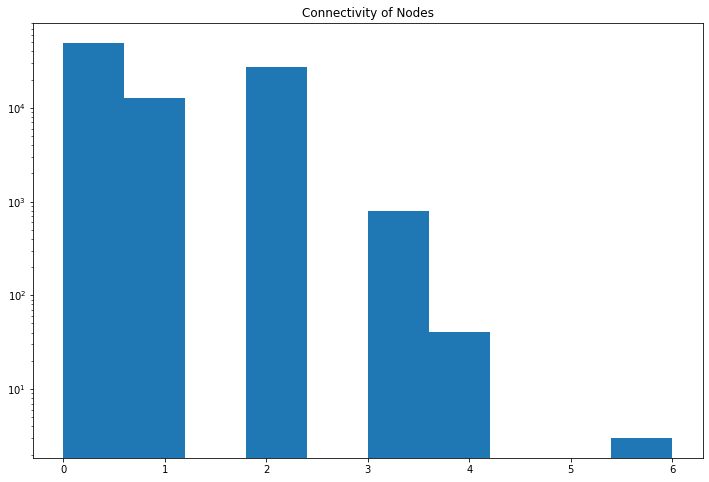

CPU times: user 511 ms, sys: 123 ms, total: 634 ms
Wall time: 483 ms


In [7]:
%%time
import scipy.sparse as sparse
def build_neighbors_list(nodes, edges):
    
    device = "cuda"
    
    if torch.is_tensor(edges):
        edges = edges.cpu().numpy()
        
    neighbors_list = sparse.coo_matrix((np.ones(edges.shape[1]), edges),
                                   shape=(nodes.shape[0], nodes.shape[0])).tocsr()
    neighbors_list = (neighbors_list + neighbors_list.T) > 0
    counts = neighbors_list.sum(axis = 1)
    
    max_neighbors = counts.max()
        
    counts = torch.tensor(max_neighbors - counts).to(device)
    counts[counts < 0] = 0
    indices = torch.arange(nodes.shape[0], nodes.shape[0] + max_neighbors).repeat((nodes.shape[0],1)).long().to(device)
    indices[indices >= counts.to(device) + nodes.shape[0]] = -1
    positive_indices = indices >= 0
    idx = torch.arange(nodes.shape[0]).repeat((max_neighbors,1)).T.to(device)
    complement_row = idx[positive_indices].cpu().numpy()
    complement_col = indices[positive_indices].cpu().numpy()
    neighbors_list = neighbors_list.tocoo()
    neighbors_list = sparse.coo_matrix((np.ones(len(neighbors_list.row) + len(complement_row)),
                                        (np.concatenate([neighbors_list.row, complement_row], axis = 0),
                                          np.concatenate([neighbors_list.col, complement_col], axis = 0)
                                          )
                                       ),
                                       shape=(nodes.shape[0], nodes.shape[0] + max_neighbors)
                                      ).tocsr()
    
    neighbors_list = neighbors_list.indices.reshape((nodes.shape[0], max_neighbors))
    neighbors_list = torch.tensor(neighbors_list, device = device)
    neighbors_list[neighbors_list >= nodes.shape[0]] = -1
    
    return neighbors_list

counts = build_neighbors_list(batch.pid, batch.modulewise_true_edges) >= 0
counts = counts.sum(-1).cpu().numpy()
plt.figure(figsize = (12,8))
plt.title("Connectivity of Nodes")
plt.hist(counts, density=False, bins=10, log = True, )
plt.show()

In [6]:
%%time
def smaple_triplets(nodes, edges, n_triplets_per_node, neighbors = None):
    if neighbors == None:
        neighbors = build_neighbors_list(nodes, edges)
    device = "cuda"
    n_triplets_per_node = min(n_triplets_per_node, neighbors.shape[1]//2)
    neighbors = neighbors[:, torch.randperm(neighbors.shape[1])]
    
    # Randomize list
    indices = torch.argsort((neighbors >= 0).int().reshape(neighbors.shape), descending = True)
    indices = (indices + torch.arange(indices.shape[0], device = device).unsqueeze(1)*indices.shape[1]).flatten()
    neighbors = neighbors.flatten()[indices].reshape(neighbors.shape)
    
    # Slicing samples consecutively
    slices = torch.arange(2*n_triplets_per_node, device = device).reshape(-1, 2)
    ind = torch.arange(neighbors.shape[0], device = device)
    triplet_list = torch.cat(
        [torch.stack([ind, neighbors[:, slices[i,0]], neighbors[:, slices[i, 1]]], dim = 0) for i in range(n_triplets_per_node)],
        dim = 1)
    triplet_list = triplet_list[:,(triplet_list != -1).all(0)]
    
    return triplet_list

smaple_triplets(batch.pid, batch.modulewise_true_edges, 1000, batch.idxs).shape

CPU times: user 157 ms, sys: 0 ns, total: 157 ms
Wall time: 161 ms


torch.Size([3, 4550045])

In [5]:
import networkx as nx

In [6]:
counter = 0
colors = ["red", "blue"]
node_colors = []
masks = []
edges = []
pids = []
i = 0
values, counts = batch.modulewise_true_edges.unique(return_counts = True)
pid_list = batch.pid[values[counts.argsort(descending = True)]].unique_consecutive()
while len(pids) < len(colors):
    pid = pid_list[i]
    if pid not in pids:
        pids.append(pid)
    i += 1

for i in range(len(colors)):
    edge = batch.modulewise_true_edges[:, (batch.pid[batch.modulewise_true_edges] == pids[i]).any(0)]
    mask = edge.unique()
    masks.extend(mask.tolist())
    inverse_mask = torch.arange(edge.max() + 1)
    inverse_mask[edge.unique()] = torch.arange(counter, counter + edge.unique().shape[0])
    node_colors.extend([colors[i]]*edge.unique().shape[0])
    counter = counter + edge.unique().shape[0]
    edge = inverse_mask[edge].T.tolist()
    edges.extend(edge)

In [7]:
pos = {}

for i in range(len(masks)):
    pos[i] = np.array([batch.x[masks[i],2].item(),
                       batch.x[masks[i],0].item()*batch.x[masks[i],1].item()])
    # pos[i] = np.array([(batch.x[masks[i],0]*torch.cos(batch.x[masks[i],1]*torch.pi)).item(),
    #                     (batch.x[masks[i],0]*torch.sin(batch.x[masks[i],1]*torch.pi)).item()])

In [8]:
G = nx.Graph()
G.add_nodes_from(range(torch.tensor(edges).max()))
G.add_edges_from(edges)

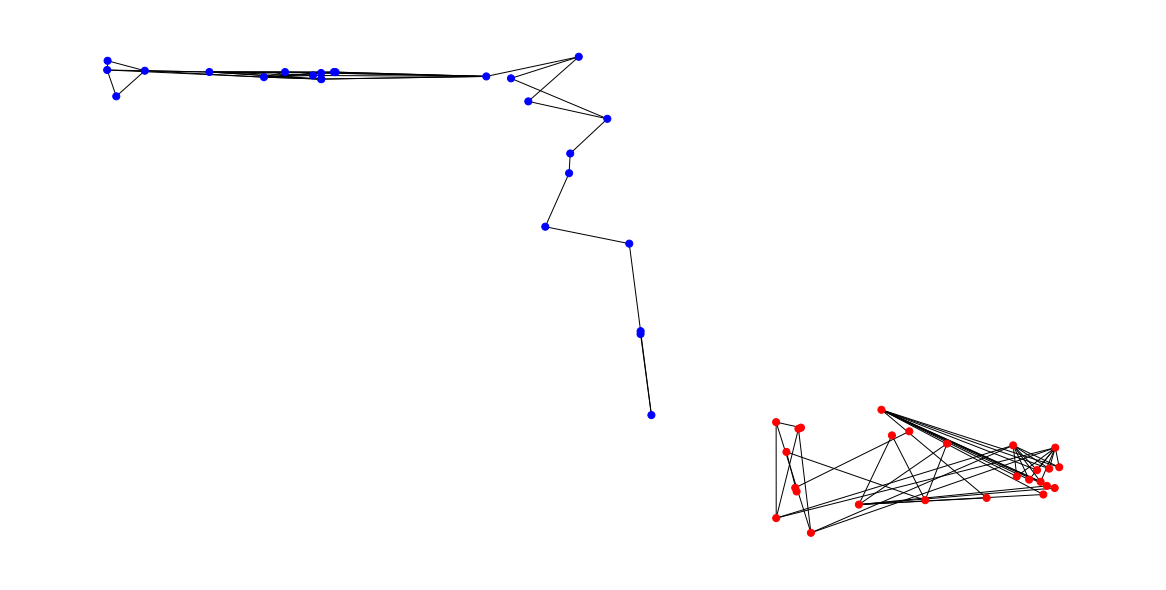

In [278]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
nx.draw(G, pos=pos, node_color = node_colors, node_size = 50)
plt.draw()

In [1]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import frnn

sys.path.append('../..')

from LightningModules.EdgeEmbedding.edge_embedding_base import EdgeEmbeddingBase
from LightningModules.EdgeEmbedding.utils import build_neighbors_list

In [2]:
event = torch.load("/global/cfs/cdirs/m3443/usr/ryanliu/ITk_filter/filter_processed/test/10002")

In [3]:
with open("/global/homes/r/ryanliu/Tracking-ML-Exa.TrkX/Pipelines/Common_Tracking_Example/notebooks/ITk/edge_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)
model = EdgeEmbeddingBase(hparams)
model.cuda()
event.cuda()

Data(cell_data=[90297, 11], event_file="/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010002", hid=[90297], idxs=[90297, 500], idxs_scores=[90297, 500], modulewise_true_edges=[2, 34884], nhits=[90297], pid=[90297], primary=[90297], pt=[90297], x=[90297, 3], y=[45058203])

In [4]:
event.ind = torch.arange(event.idxs.shape[0])[torch.randperm(event.idxs.shape[0])][:500]
event.idxs = event.idxs[event.ind, :20].long()

In [7]:
neighbors = build_neighbors_list(event.pid, event.modulewise_true_edges, device = "cuda")[event.ind]
embeddings = torch.rand((event.idxs.shape[0], event.idxs.shape[1] , 22), device = "cuda")

In [8]:
d, hinge, weights = model.get_hinge_distance(embeddings, event, r_max = 1.0, k_max = 10, mode = "pid_fake")